In [1]:
import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=16)        
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39007,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:46491,Total threads: 1
Dashboard: /proxy/36463/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:40155,


### First, get the shelf mask

CPU times: user 4.28 s, sys: 2.27 s, total: 6.55 s
Wall time: 9.82 s


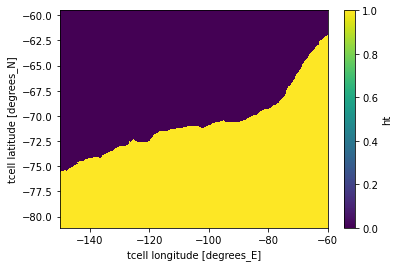

In [2]:
%%time
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht

bath_mask = xr.where(field.isel(xt_ocean=slice(1299,2200),yt_ocean=slice(0,500))<=1000,1,0)
bath_mask[:396,886:] = bath_mask[:396,886:].where(bath_mask[:396,886:]!=1, 0) # manually mask out all the other sea mounts and the region
bath_mask[:170,500:] = bath_mask[:170,500:].where(bath_mask[:170,500:]!=1, 0) # in the western Weddell Sea
bath_mask[270:,:670] = bath_mask[270:,:670].where(bath_mask[270:,:670]!=1, 0)
bath_mask[410:,:840] = bath_mask[410:,:840].where(bath_mask[410:,:840]!=1, 0)
bath_mask[:390,878:] = bath_mask[:390,878:].where(bath_mask[:390,878:]!=1, 0)

# and also unmasking the grid cells that are seamounts on the shelf
bath_mask[:130,:] = bath_mask[:130,:].where(bath_mask[:130,:]!=0, 1)
bath_mask[:140,35:200] = bath_mask[:140,35:200].where(bath_mask[:140,35:200]!=0, 1)
bath_mask[:160,90:200] = bath_mask[:160,90:200].where(bath_mask[:160,90:200]!=0, 1)
bath_mask[:180,180:200] = bath_mask[:180,180:200].where(bath_mask[:180,180:200]!=0, 1)
bath_mask[:190,193:] = bath_mask[:190,193:].where(bath_mask[:190,193:]!=0, 1)
bath_mask[:230,440:] = bath_mask[:230,440:].where(bath_mask[:230,440:]!=0, 1)
bath_mask[:290,725:] = bath_mask[:290,725:].where(bath_mask[:290,725:]!=0, 1)
bath_mask[:320,760:] = bath_mask[:320,760:].where(bath_mask[:320,760:]!=0, 1)
bath_mask[:360,800:] = bath_mask[:360,800:].where(bath_mask[:360,800:]!=0, 1)
bath_mask[:360,800:] = bath_mask[:360,800:].where(bath_mask[:360,800:]!=0, 1)
bath_mask[:415,850:] = bath_mask[:415,850:].where(bath_mask[:415,850:]!=0, 1)
bath_mask[:395,830:] = bath_mask[:395,830:].where(bath_mask[:395,830:]!=0, 1)
bath_mask[400:438,873:] = bath_mask[400:438,873:].where(bath_mask[400:438,873:]!=0, 1)
bath_mask[400:440,890:] = bath_mask[400:440,890:].where(bath_mask[400:440,890:]!=0, 1)

above1000_tcells = bath_mask

# above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
# above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000
# field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
above1000_tcells.plot()
# # Wall time: 51.6 s

### Loading in the heat budget terms

In [3]:
%%time 
base   = '/g/data/e14/mv7494/access-om2/archive/'
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_LNFull']
# --------------------------------------------------------------------------------------------------------------------------------- #
depth     = [  23,   47]  # [ 23,   47] = 97.6 m - 1017 m, [24,   40] = 108.9 - 517.6 m                                             #
sel_lat   = [   0,  500]  # [120,  263] = 76.03°S - 70.04°S                                                                         #
sel_lon   = [1299, 2200]  # 150°W - 60°W                                                                                            #
rho_0     = 1035          # reference density [1035 kg * m^-3]                                                                      #
C_p       = 3992.1        # reference specific heat capacity [3992.1 J * kg^-1 * K^-1]                                              #
area_t    = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]    #
dyu       = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').dyu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]       #
dxu       = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_grid.nc').dxu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]       #
# --------------------------------------------------------------------------------------------------------------------------------- #

# load in variables
average_DT = xr.open_mfdataset(base+exp[0]+'/output976/ocean/ocean_month.nc', decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 
average_DT # 2592000.0 s per time step

temp_tendency_clim    = xr.open_mfdataset(base+exp[0]+'/output*/ocean/ocean_heat.nc').temp_tendency[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_tendency_LN      = xr.open_mfdataset(base+exp[1]+'/output*/ocean/ocean_heat.nc').temp_tendency[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_tendency         = ((temp_tendency_LN - temp_tendency_clim) * above1000_tcells * area_t * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()

# now the same for the heat flux convergence
temp_advection_clim    = xr.open_mfdataset(base+exp[0]+'/output*/ocean/ocean_heat.nc').temp_advection[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_advection_LN      = xr.open_mfdataset(base+exp[1]+'/output*/ocean/ocean_heat.nc').temp_advection[:, depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_advection         = ((temp_advection_LN - temp_advection_clim) * above1000_tcells * area_t * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
# Wall time: 21.9 s

CPU times: user 7.37 s, sys: 1.12 s, total: 8.49 s
Wall time: 31.4 s


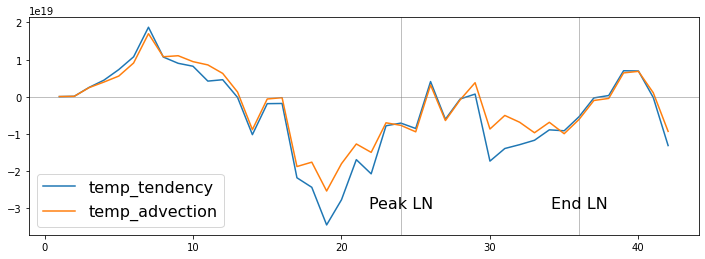

In [4]:
plt.figure(figsize=(12,4)); time = np.linspace(1,len(temp_tendency),len(temp_tendency))
plt.plot(time, temp_tendency, label='temp_tendency')
plt.plot(time, temp_advection, label='temp_advection')
plt.axhline(0, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.text(24,-3e19,'Peak LN', ha='center', fontsize=16)
plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End LN', ha='center', fontsize=16)
plt.legend(fontsize=16)

### Okay, so far, so good!

-----------------------------------------------------------------------------------------

### Next, loading in the transport masks

CPU times: user 107 ms, sys: 30.8 ms, total: 138 ms
Wall time: 117 ms


Text(0.5, 1.0, 'mask_y_transport_ucells')

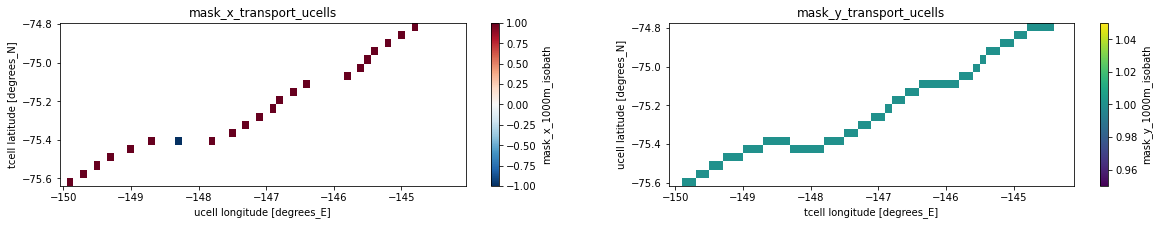

In [5]:
%%time
# loading in the transport masks from Claire's script called 'Cross-contour_transport.ipynb'
# her original script is in the COSIMA recipe repo: https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Cross-contour_transport.html
base_mask = '/g/data/e14/mv7494/ACCESS-OM2-01_transport_masks/'
mask_x_transport_ucells = xr.open_dataset(base_mask + 'mask_x_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_x_1000m_isobath.rename(
    {'y_ocean': 'yt_ocean', 'x_ocean': 'xu_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]] * -1
mask_x_transport_ucells = mask_x_transport_ucells.where(mask_x_transport_ucells != 0) # replace all zero with nan
mask_y_transport_ucells = xr.open_dataset(base_mask + 'mask_y_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_y_1000m_isobath.rename(
    {'y_ocean': 'yu_ocean', 'x_ocean': 'xt_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
mask_y_transport_ucells = mask_y_transport_ucells.where(mask_y_transport_ucells != 0)

# -------------------------------------------------- #
# multiply with -1 to get across-shelf, poleward directed mask (that is, each flux going south/in almost all cases east across the mask is positive)
# mask_x_transport_ucells = mask_x_transport_ucells * -1
# mask_y_transport_ucells = mask_y_transport_ucells * -1
# -------------------------------------------------- #

plt.figure(figsize=(20,3)); plt.subplot(1,2,1); mask_x_transport_ucells[130:150,:60].plot(); plt.title('mask_x_transport_ucells')
plt.subplot(1,2,2); mask_y_transport_ucells[130:150,:60].plot(); plt.title('mask_y_transport_ucells')
# Wall time: 155 ms

Text(0.5, 1.0, 'all in one panel')

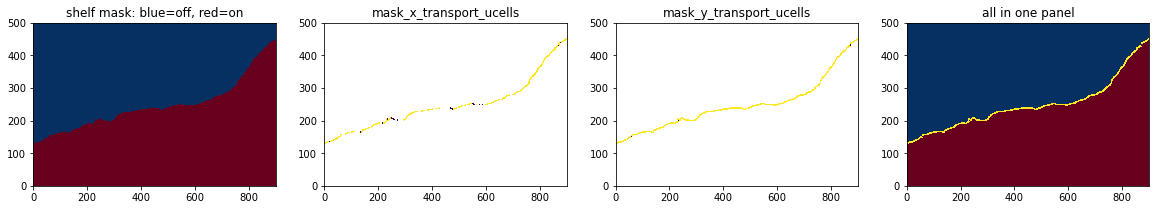

In [6]:
plt.figure(figsize=(20,3))
plt.subplot(1,4,1); plt.pcolor(above1000_tcells, cmap='RdBu_r'); plt.title('shelf mask: blue=off, red=on')
plt.subplot(1,4,2); plt.pcolor(mask_x_transport_ucells); plt.title('mask_x_transport_ucells')
plt.subplot(1,4,3); plt.pcolor(mask_y_transport_ucells); plt.title('mask_y_transport_ucells')
plt.subplot(1,4,4); plt.pcolor(above1000_tcells, cmap='RdBu_r'); plt.pcolor(mask_x_transport_ucells); plt.pcolor(mask_y_transport_ucells)
plt.title('all in one panel')

### Checking again if the transport masks and the tx_trans/ty_trans variables are on the same grid

Text(0.5, 1.0, 'All good, grids are identical ✓')

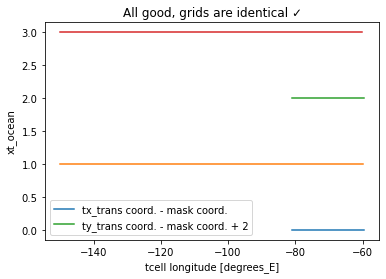

In [7]:
tx_trans = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull/output976/ocean/ocean_month.nc').tx_trans[0,0,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
(tx_trans.yt_ocean - mask_x_transport_ucells.yt_ocean).plot(label='tx_trans coord. - mask coord.'); (tx_trans.xu_ocean - mask_x_transport_ucells.xu_ocean+1).plot()

# same for ty_trans and its mask
ty_trans = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull/output976/ocean/ocean_month.nc').ty_trans[0,0,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
(ty_trans.yu_ocean - mask_y_transport_ucells.yu_ocean+2).plot(label='ty_trans coord. - mask coord. + 2'); (ty_trans.xt_ocean - mask_y_transport_ucells.xt_ocean+3).plot()
plt.legend(); plt.title('All good, grids are identical ✓')

### Loading in the variables to calculate the cross-shelf heat fluxes

In [8]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']

# ---------------------------------------------------------------------------------- #
for e in [2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 2: last_output = 989; nr_outputs = 14 # La Nina simulation goes from output976 to output989

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 
        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]
        
    # average time in seconds per month (the output is saved in ns, that's why /1e9)      
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.astype('int') / 1e9 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    # the same for the two velocities
    tx_trans_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).tx_trans[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    tx_trans        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).tx_trans[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    ty_trans_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).ty_trans[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    ty_trans        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).ty_trans[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 2: 
        # interpolate the temperatures onto the transport grids (either [yt,xu] for the zonal component or [yu,xt] for the meridional component)
        tempx_LN_anom = (temp  - temp_clim).interp(xt_ocean=tx_trans.xu_ocean.values,method='nearest').rename({'xt_ocean':'xu_ocean'})
        tempy_LN_anom = (temp  - temp_clim).interp(yt_ocean=ty_trans.yu_ocean.values,method='nearest').rename({'yt_ocean':'yu_ocean'})
        tx_trans_LN_anom    = (tx_trans     - tx_trans_clim)
        ty_trans_LN_anom    = (ty_trans     - ty_trans_clim)
        # and the same for the cell thickness
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 9.66 s, sys: 843 ms, total: 10.5 s
Wall time: 10.1 s


In [9]:
%%time
# here the calculation of the across-shelf heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) ----------------------------------------------- #
across_x_flux = (C_p * tx_trans_LN_anom * tempx_LN_anom * average_DT * mask_x_transport_ucells).sum(['st_ocean', 'yt_ocean', 'xu_ocean']).load()
across_y_flux = (C_p * ty_trans_LN_anom * tempy_LN_anom * average_DT * mask_y_transport_ucells).sum(['st_ocean', 'yu_ocean', 'xt_ocean']).load()
across_heat_flux = (across_x_flux+across_y_flux)
# Wall time: 34.5 s

CPU times: user 10.1 s, sys: 1.02 s, total: 11.1 s
Wall time: 35.9 s


CPU times: user 34.5 ms, sys: 3.71 ms, total: 38.2 ms
Wall time: 33 ms


Text(0.5, 0, 'Month')

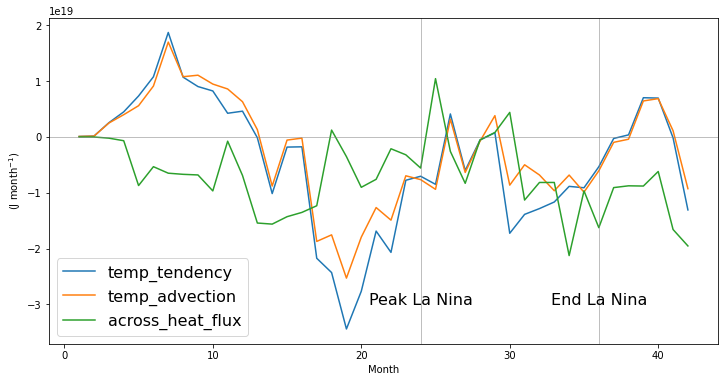

In [10]:
%%time
plt.figure(figsize=(12,6)); time = np.linspace(1,len(temp_tendency),len(temp_tendency))
plt.plot(time, temp_tendency, label='temp_tendency')
plt.plot(time, temp_advection, label='temp_advection')
plt.plot(time, across_heat_flux*-1, label='across_heat_flux')
plt.axhline(0, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.text(24,-3e19,'Peak La Nina', ha='center', fontsize=16)
plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End La Nina', ha='center', fontsize=16)
plt.legend(fontsize=16); plt.ylabel('(J month$^{-1}$)'); plt.xlabel('Month')
# Wall time: 38.8 ms

### Work in progress here

CPU times: user 2.9 s, sys: 281 ms, total: 3.18 s
Wall time: 9.02 s


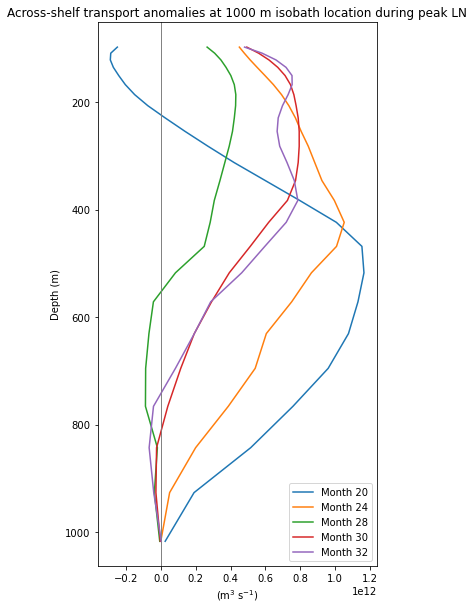

In [11]:
# %%time
# plt.figure(figsize=(5,10))
# for f in [20, 24, 28, 30, 32]:
#     across_x_flux = (tx_trans_LN_anom * average_DT / rho_0 * mask_x_transport_ucells)[f,:,:,:].sum(['yt_ocean', 'xu_ocean'])
#     across_y_flux = (ty_trans_LN_anom * average_DT / rho_0 * mask_y_transport_ucells)[f,:,:,:].sum(['yu_ocean', 'xt_ocean'])
#     p1 = plt.plot((across_x_flux+across_y_flux)*-1, across_x_flux.st_ocean, label='Month '+str(f))
#     plt.gca().invert_yaxis(); plt.title('Across-shelf transport anomalies at 1000 m isobath location during peak LN')
#     plt.axvline(0, lw=.5, c='grey'); plt.ylabel('Depth (m)'); plt.xlabel('(m$^{3}$ s$^{-1}$)')
#     # Wall time: 4.41 s
# plt.legend()

# Backup below here

--------------------------------------------------------------------------------------------------------------------------------------------

### Loading in the variables to calculate the cross-shelf heat fluxes

In [12]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']

# ---------------------------------------------------------------------------------- #
for e in [2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 2: last_output = 989; nr_outputs = 14 # La Nina simulation goes from output976 to output989

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 
        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]
        
    # average time in seconds per month (the output is saved in ns, that's why /1e9)      
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    # the same for the two velocities
    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    dzt      = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).dzt[0, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 2: 
        # interpolate the temperatures onto the u-grid (yu_ocean, xu_ocean)
        temp_LN_anom = (temp  - temp_clim).interp(yt_ocean=u.yu_ocean.values,xt_ocean=u.xu_ocean.values,method='nearest').rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
        u_LN_anom    = (u     - u_clim)
        v_LN_anom    = (v     - v_clim)
        # and the same for the cell thickness
        dzu_LN       = dzt.interp(yt_ocean=u.yu_ocean.values,xt_ocean=u.xu_ocean.values,method='nearest').rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 11.6 s, sys: 916 ms, total: 12.6 s
Wall time: 11.6 s


### Here the heavy lifting (i.e., calculating the poleward cross-shelf heat flux across the 1000 m isobath)
$\rightarrow$ for now without the uncertainty

In [13]:
# %%time
# # here the calculation of the across-shelf heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) ----------------------------------------------- #
# across_x_flux = (rho_0 * C_p * u_LN_anom * temp_LN_anom * dzu_LN * dyu * average_DT * mask_x_transport_ucells).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
# across_y_flux = (rho_0 * C_p * v_LN_anom * temp_LN_anom * dzu_LN * dxu * average_DT * mask_y_transport_ucells).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
# across_heat_flux = (across_x_flux+across_y_flux)
# # Wall time: 

In [14]:
# %%time
# plt.figure(figsize=(12,6)); time = np.linspace(1,len(temp_tendency),len(temp_tendency))
# plt.plot(time, temp_tendency, label='temp_tendency')
# plt.plot(time, temp_advection, label='temp_advection')
# plt.plot(time, across_heat_flux*-1, label='across_heat_flux')
# plt.axhline(0, c='grey', lw=.5); plt.axvline(24, c='grey', lw=.5); plt.text(24,-3e19,'Peak La Nina', ha='center', fontsize=16)
# plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End La Nina', ha='center', fontsize=16)
# plt.legend(fontsize=16); plt.ylabel('(J month$^{-1}$)')
# # Wall time: 38.8 ms

### Adding the online across_heat_flux calculated from the model output (so far, only ran 3 months)

In [15]:
%%time
exp = ['01deg_jra55_ryf_Control_transport', '01deg_jra55_ryf_LNFull_transport']
# first, the zonal heat flux for those grid cells that are East-
temp_xflux_adv_clim = xr.open_dataset(base[0]+exp[0] + '/output976/ocean/ocean_heat.nc').temp_xflux_adv[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_xflux_adv      = xr.open_dataset(base[1]+exp[1] + '/output976/ocean/ocean_heat.nc').temp_xflux_adv[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
# interpolating the yt_ocean grid coordinate onto the yu_ocean coordinate
temp_xflux_adv_LN = (temp_xflux_adv - temp_xflux_adv_clim) 
# multiply the flux with Claire's isobath mask
temp_xflux_adv_LN = (temp_xflux_adv_LN *mask_x_transport_ucells*average_DT).cumsum(['time']).sum(['st_ocean', 'yt_ocean', 'xu_ocean']).load() # take cumulative sum as in my OHC study

# and now the same for the meridional heat flux as well
temp_yflux_adv_clim = xr.open_dataset(base[0]+exp[0] + '/output976/ocean/ocean_heat.nc').temp_yflux_adv[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_yflux_adv      = xr.open_dataset(base[1]+exp[1] + '/output976/ocean/ocean_heat.nc').temp_yflux_adv[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_yflux_adv_LN = (temp_yflux_adv - temp_yflux_adv_clim)
temp_yflux_adv_LN = (temp_yflux_adv_LN *mask_y_transport_ucells*average_DT).cumsum(['time']).sum(['st_ocean', 'yu_ocean', 'xt_ocean']).load() # take cumulative sum as in my OHC study

CPU times: user 7.49 s, sys: 1.6 s, total: 9.09 s
Wall time: 7.89 s


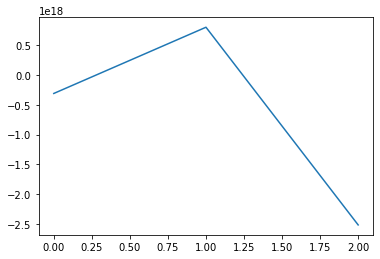

In [16]:
plt.plot(temp_xflux_adv_LN+temp_yflux_adv_LN)

CPU times: user 37.8 ms, sys: 2.33 ms, total: 40.1 ms
Wall time: 35.7 ms


(-1e+19, 2e+19)

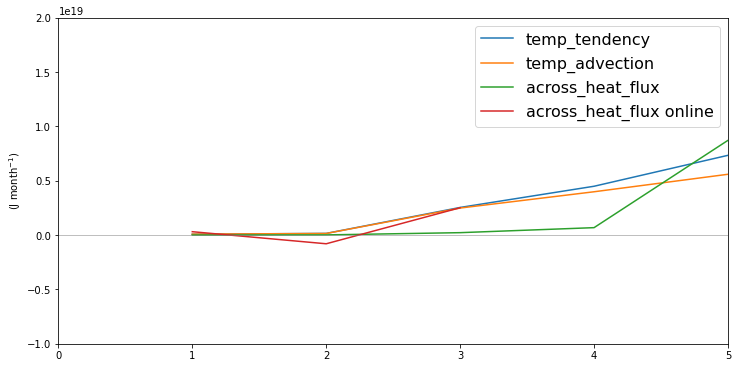

In [17]:
%%time
plt.figure(figsize=(12,6)); time = np.linspace(1,len(temp_tendency),len(temp_tendency)); time2 = np.linspace(1,len(temp_xflux_adv_LN),len(temp_xflux_adv_LN))
plt.plot(time, temp_tendency, label='temp_tendency')
plt.plot(time, temp_advection, label='temp_advection')
plt.plot(time, across_heat_flux, label='across_heat_flux')
plt.plot(time2,(temp_xflux_adv_LN+temp_yflux_adv_LN)*-1, label='across_heat_flux online')
plt.axhline(0, c='grey', lw=.5)
plt.axvline(24, c='grey', lw=.5)
# plt.text(24,-3e19,'Peak La Nina', ha='center', fontsize=16)
# plt.axvline(36, c='grey', lw=.5); plt.text(36,-3e19,'End La Nina', ha='center', fontsize=16)
plt.legend(fontsize=16); plt.ylabel('(J month$^{-1}$)')
plt.xlim(0,5); plt.ylim(-1e19,2e19)
# Wall time: 

In [18]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #